In [4]:
import os
import wfdb
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# Define the path to your dataset directory
DATA_DIR = "C:/Users/M2-Winterfell/Downloads/electrocardiography-dataset-1.0.3/records500/00000"

# Function to load and extract Lead I and Lead II from a single record
def load_ecg_leads(file_path):
    try:
        # Load the record using wfdb (the file_path should be without extension)
        record = wfdb.rdrecord(file_path)
        
        # Extract Lead I and Lead II (assuming they are the first two leads)
        lead_I = record.p_signal[:, 0]  # Lead I
        lead_II = record.p_signal[:, 1]  # Lead II
        
        return lead_I, lead_II
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Function to load only the first 1000 ECG records
def load_first_n_ecg_data(data_dir, n=1000):
    all_lead_I = []
    all_lead_II = []
    
    count = 0  # To keep track of the number of records loaded
    
    # Traverse through all subdirectories in records500
    for root, dirs, files in os.walk(data_dir):
        for file in tqdm(files, desc="Loading ECG files"):
            if file.endswith("_hr.dat"):  # Look for files with the _hr suffix
                # Stop loading after reaching the first n records
                if count >= n:
                    break
                
                # Construct the base filename (removing the '_hr.dat' extension)
                base_filename = file.replace("_hr.dat", "_hr")
                record_path = os.path.join(root, base_filename)
                
                # Load Lead I and Lead II
                lead_I, lead_II = load_ecg_leads(record_path)
                
                if lead_I is not None and lead_II is not None:
                    all_lead_I.append(lead_I)
                    all_lead_II.append(lead_II)
                    count += 1
                else:
                    print(f"Skipping record: {base_filename}")

        if count >= n:  # Break the outer loop as well
            break
    
    # Convert lists to NumPy arrays if data was loaded
    if all_lead_I and all_lead_II:
        all_lead_I = np.array(all_lead_I)  # Shape: (num_records, samples_per_record)
        all_lead_II = np.array(all_lead_II)  # Shape: (num_records, samples_per_record)
    else:
        all_lead_I = np.array([])  # Empty array if no data
        all_lead_II = np.array([])  # Empty array if no data
    
    return all_lead_I, all_lead_II

# Load only the first 1000 ECG records from records500
lead_I_data, lead_II_data = load_first_n_ecg_data(DATA_DIR, n=1000)

# Check if data was loaded successfully
if lead_I_data.size > 0 and lead_II_data.size > 0:
    print(f"Total records loaded: {lead_I_data.shape[0]}")
    print(f"Each record has {lead_I_data.shape[1]} samples per lead.")
    
    # Check shapes
    print("Lead I data shape:", lead_I_data.shape)
    print("Lead II data shape:", lead_II_data.shape)
else:
    print("No data was loaded.")


Loading ECG files: 100%|██████████| 1974/1974 [00:16<00:00, 120.66it/s]


Total records loaded: 987
Each record has 5000 samples per lead.
Lead I data shape: (987, 5000)
Lead II data shape: (987, 5000)


In [7]:
import pandas as pd

# 假设 lead_I_data 是你的 Lead I 数据，形状为 (987, 5000)
# 将 NumPy 数组转换为 pandas DataFrame
lead_I_df = pd.DataFrame(lead_I_data)

# 将 DataFrame 保存为 CSV 文件
lead_I_df.to_csv("lead_I_data.csv", index=False)

print("Lead I data has been saved to lead_I_data.csv")

Lead I data has been saved to lead_I_data.csv


Physiological thresholds and manual feature extraction

- Fiducial Points: P, Q, R, S, and T waves
- Compute interval and amplitude features: PR interval, QRS duration and QT interval
- Compared against thresholds based on human physiological values

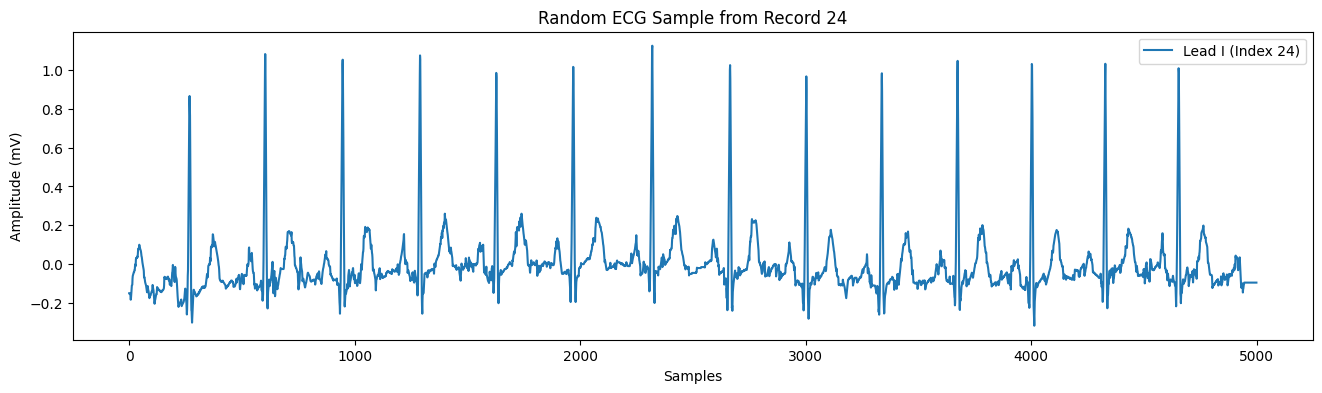

c:\Users\M2-Winterfell\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


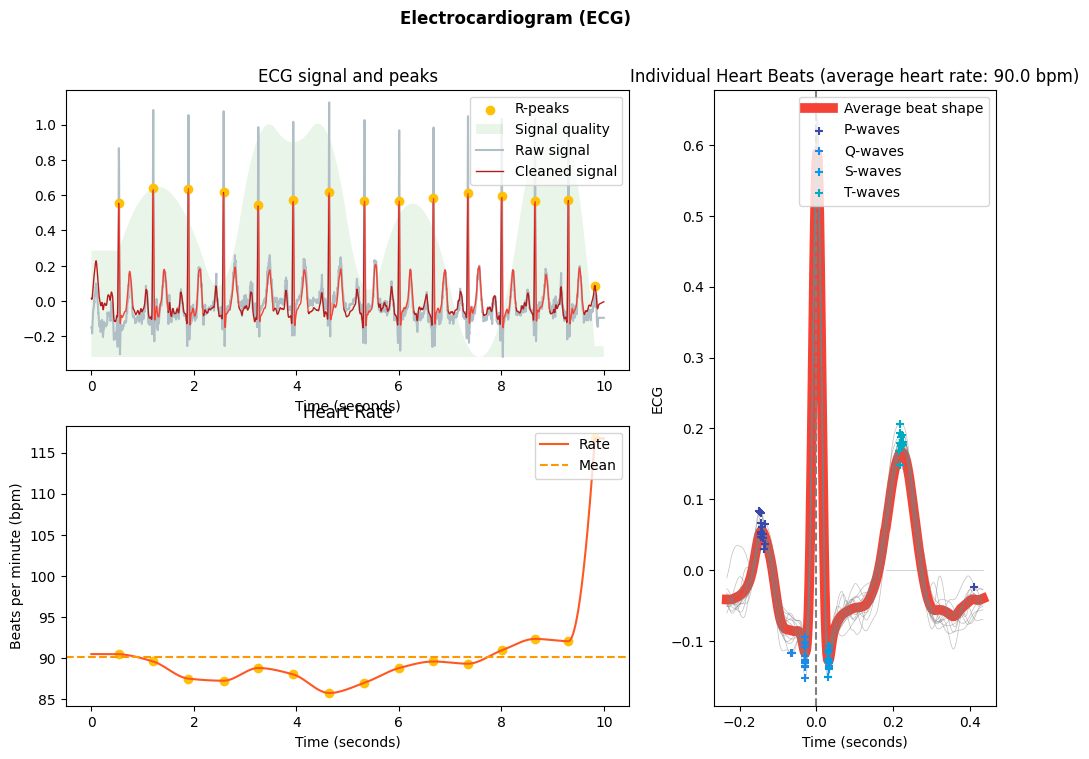

Detected beats: 15
PR interval mean (ms):  178.40
QRS duration mean (ms): 111.29
QT interval mean (ms):  344.57
P wave duration mean (ms): 86.93
R amplitude mean (mV): 0.5556
T amplitude mean (mV): 0.1800

Conclusion about record 24: Human


In [2]:
import random
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np

###############################################################################
# 1) Define your fiducial-based "is_human_ecg" function (rule-based approach) #
###############################################################################
def is_human_ecg(ecg_signal, fs=500, verbose=False):
    """
    Decide if the given ECG snippet is 'Real' or 'Fake' based purely on
    fiducial measurements (intervals, amplitudes) compared against
    typical physiological ranges.
    """
    import neurokit2 as nk
    import numpy as np

    # 1) Preprocessing & R-peak detection
    try:
        signals, info = nk.ecg_process(ecg_signal, sampling_rate=fs)
    except Exception as e:
        if verbose:
            print(f"[Error] NeuroKit2 failed to process ECG: {e}")
        return "Fake"

    r_peaks = info["ECG_R_Peaks"]
    if len(r_peaks) < 2:
        if verbose:
            print("[Warning] Not enough R-peaks detected => likely Fake.")
        return "Fake"

    # 2) Delineation to find wave boundaries
    try:
        delineation_signals, wave_peaks = nk.ecg_delineate(
            signals["ECG_Clean"], 
            r_peaks, 
            sampling_rate=fs, 
            method="dwt"
        )
    except Exception as e:
        if verbose:
            print(f"[Error] Could not delineate waves: {e}")
        return "Fake"

    # Prepare lists for intervals/amplitudes
    pr_intervals = []
    qrs_durations = []
    qt_intervals = []
    p_durations = []
    r_amplitudes = []
    t_amplitudes = []

    for idx, r_idx in enumerate(r_peaks):
        # Instead of delineation["ECG_P_Onsets"], we now call wave_peaks["ECG_P_Onsets"]
        p_onset  = wave_peaks["ECG_P_Onsets"][idx]   if idx < len(wave_peaks["ECG_P_Onsets"])   else None
        p_offset = wave_peaks["ECG_P_Offsets"][idx]  if idx < len(wave_peaks["ECG_P_Offsets"])  else None
        q_onset  = wave_peaks["ECG_R_Onsets"][idx]   if idx < len(wave_peaks["ECG_R_Onsets"])   else None
        s_offset = wave_peaks["ECG_R_Offsets"][idx]  if idx < len(wave_peaks["ECG_R_Offsets"])  else None
        t_onset  = wave_peaks["ECG_T_Onsets"][idx]   if idx < len(wave_peaks["ECG_T_Onsets"])   else None
        t_offset = wave_peaks["ECG_T_Offsets"][idx]  if idx < len(wave_peaks["ECG_T_Offsets"])  else None
        p_peak   = wave_peaks["ECG_P_Peaks"][idx]    if idx < len(wave_peaks["ECG_P_Peaks"])    else None
        t_peak   = wave_peaks["ECG_T_Peaks"][idx]    if idx < len(wave_peaks["ECG_T_Peaks"])    else None

        # Skip if any critical index is None
        if any(v is None for v in [p_onset, p_offset, q_onset, s_offset, t_onset, t_offset]):
            continue

        # Convert samples -> ms
        p_onset_time   = p_onset   / fs * 1000
        p_offset_time  = p_offset  / fs * 1000
        q_onset_time   = q_onset   / fs * 1000
        s_offset_time  = s_offset  / fs * 1000
        r_time         = r_idx     / fs * 1000
        t_onset_time   = t_onset   / fs * 1000
        t_offset_time  = t_offset  / fs * 1000

        # PR interval (ms)
        pr_interval_ms = r_time - p_onset_time
        if pr_interval_ms > 0:
            pr_intervals.append(pr_interval_ms)

        # QRS duration (ms) - approx with s_offset - q_onset
        qrs_duration_ms = s_offset_time - q_onset_time
        if qrs_duration_ms > 0:
            qrs_durations.append(qrs_duration_ms)

        # QT interval (ms) - approx with t_offset - q_onset
        qt_interval_ms = t_offset_time - q_onset_time
        if qt_interval_ms > 0:
            qt_intervals.append(qt_interval_ms)

        # P wave duration (ms)
        p_duration_ms = p_offset_time - p_onset_time
        if p_duration_ms > 0:
            p_durations.append(p_duration_ms)

        # R amplitude & T amplitude
        if r_idx < len(signals["ECG_Clean"]):
            r_amplitudes.append(signals["ECG_Clean"][r_idx])
        if t_peak is not None and t_peak < len(signals["ECG_Clean"]):
            t_amplitudes.append(signals["ECG_Clean"][t_peak])

    # If too few valid beats => suspicious
    if len(pr_intervals) < 2 or len(qrs_durations) < 2:
        if verbose:
            print("[Warning] Not enough valid beats => likely Fake.")
        return "Fake"

    # Compute means
    pr_mean  = np.mean(pr_intervals)
    qrs_mean = np.mean(qrs_durations)
    qt_mean  = np.mean(qt_intervals)  if len(qt_intervals)  > 0 else 0
    p_mean   = np.mean(p_durations)   if len(p_durations)   > 0 else 0
    r_mean   = np.mean(r_amplitudes)  if len(r_amplitudes)  > 0 else 0
    t_mean   = np.mean(t_amplitudes)  if len(t_amplitudes)  > 0 else 0

    if verbose:
        print(f"Detected beats: {len(r_peaks)}")
        print(f"PR interval mean (ms):  {pr_mean:.2f}")
        print(f"QRS duration mean (ms): {qrs_mean:.2f}")
        print(f"QT interval mean (ms):  {qt_mean:.2f}")
        print(f"P wave duration mean (ms): {p_mean:.2f}")
        print(f"R amplitude mean (mV): {r_mean:.4f}")
        print(f"T amplitude mean (mV): {t_mean:.4f}")

    # Example naive thresholds (very rough)
    if not (120 <= pr_mean <= 220):
        return "Fake"
    if not (60 <= qrs_mean <= 130):
        return "Fake"
    if not (250 <= qt_mean <= 550):
        return "Fake"
    if not (50 <= p_mean <= 140):
        return "Fake"
    if not (0.05 <= r_mean <= 3.0):
        return "Fake"
    if not (0 <= t_mean <= 1.5):
        return "Fake"

    # Looks within normal ranges => "Human"
    return "Human"


###############################################################################
# 2) Randomly pick one snippet and test
###############################################################################
if lead_I_data.size == 0:
    print("No ECG data loaded. Please check your import paths or dataset.")
else:
    fs = 500  # sampling rate
    # Randomly select a sample
    idx = random.randint(0, lead_I_data.shape[0] - 1)
    ecg_sample = lead_I_data[idx, :]  # shape: (5000,)

    # 3) Plot the raw ECG snippet
    plt.figure(figsize=(16, 4))
    plt.plot(ecg_sample, label=f"Lead I (Index {idx})")
    plt.title(f"Random ECG Sample from Record {idx}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.show()

    # 4) Process & plot the signal using NeuroKit2’s built-in function
    plt.rcParams["figure.figsize"] = (12, 8)
    signals, info = nk.ecg_process(ecg_sample, sampling_rate=fs)
    nk.ecg_plot(signals, info) 
    plt.show()

    # 5) Run our fiducial-based function to decide if it's “Human” or “Fake”
    result = is_human_ecg(ecg_sample, fs=fs, verbose=True)
    print(f"\nConclusion about record {idx}: {result}")


- Feature extraction: morphological features (like PR interval, QRS duration, and wave amplitudes) and Heart Rate Variability (HRV) metrics (such as SDNN, RMSSD, and LF/HF ratio)
- Feature used to train Logistic Regression model
- Supervised learning: Metric inclusing AUC, F1 score, accuracy and Equal Error Rate(EER)
- Feature importance analysis: Assess impact of individual features on classification decision.


Performance Metrics:
AUC: 0.50
Equal Error Rate (EER): 0.50
Accuracy: 0.67
F1 Score: 0.75


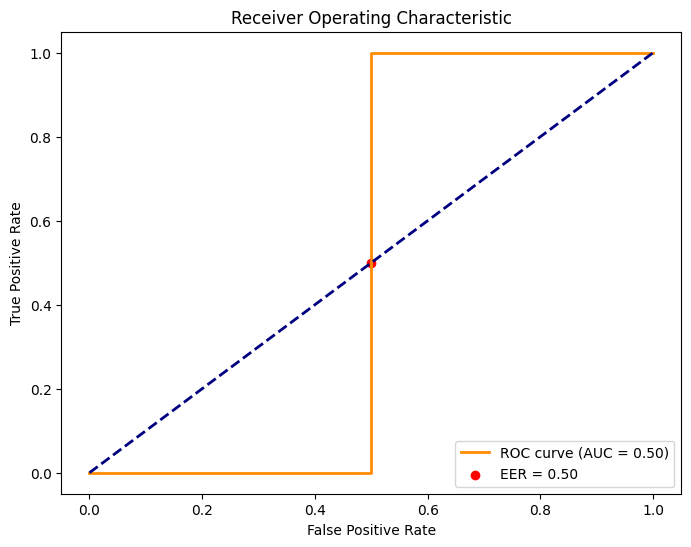


First Real ECG Features:
{'pr_mean': 166.8, 'qrs_mean': 155.77777777777777, 'qt_mean': 228.88888888888889, 'p_mean': 77.8, 'r_amp': 0.4310714603778399, 'hrv_sdnn': 17.320508075688775, 'hrv_rmssd': 22.627416997969522}

First Fake ECG Features:
{'pr_mean': 174.36363636363637, 'qrs_mean': 193.4, 'qt_mean': 442.0, 'p_mean': 82.36363636363636, 'r_amp': 0.4152356990049324, 'hrv_sdnn': 92.06278051175488, 'hrv_rmssd': 109.77957713325168}

First Real ECG HRV Metrics:
HRV SDNN: 17.32 ms
HRV RMSSD: 22.63 ms
HRV LF: nan ms²
HRV HF: nan ms²
HRV LF/HF Ratio: nan

First Fake ECG HRV Metrics:
HRV SDNN: 92.06 ms
HRV RMSSD: 109.78 ms
HRV LF: nan ms²
HRV HF: nan ms²
HRV LF/HF Ratio: nan


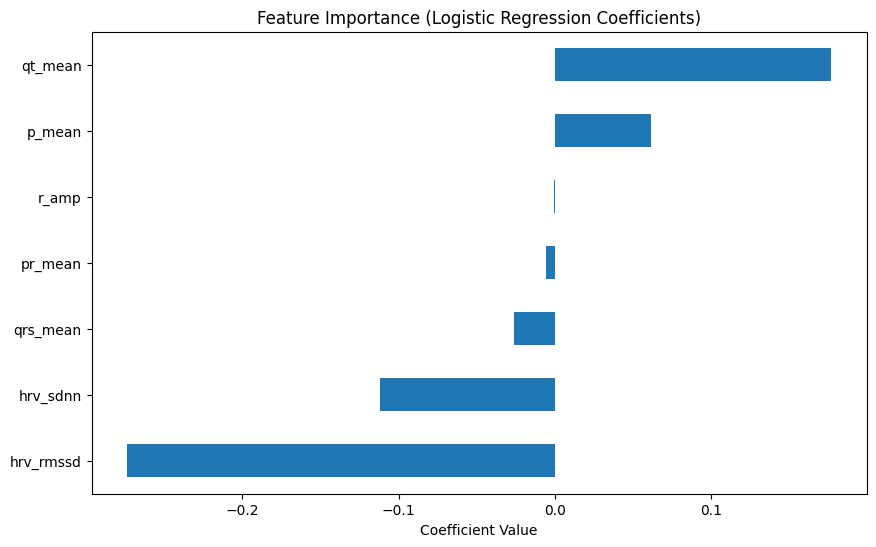

In [18]:
import random
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score
from sklearn.impute import SimpleImputer
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import pandas as pd

###############################################################################
# 1. Enhanced Feature Extraction Function with HRV Analysis                   #
###############################################################################
def extract_ecg_features(ecg_signal, fs=500):
    """Extract morphological and HRV features from ECG signal"""
    features = {}
    
    try:
        # 1. Preprocessing
        signals, info = nk.ecg_process(ecg_signal, sampling_rate=fs)
    except Exception as e:
        print(f"Processing error: {e}")
        return None

    # 2. R-peak detection
    r_peaks = info["ECG_R_Peaks"]
    if len(r_peaks) < 2:
        return None

    # 3. Morphological Feature Extraction
    try:
        _, wave_peaks = nk.ecg_delineate(signals["ECG_Clean"], r_peaks, fs, method="dwt")
    except:
        wave_peaks = {}

    # Initialize lists
    pr_values, qrs_values, qt_values = [], [], []
    p_values, r_amps, t_amps = [], [], []

    for i in range(len(r_peaks)):
        try:
            # Get wave boundaries
            p_onset = wave_peaks.get("ECG_P_Onsets", [None]*len(r_peaks))[i]
            q_onset = wave_peaks.get("ECG_R_Onsets", [None]*len(r_peaks))[i]
            s_offset = wave_peaks.get("ECG_R_Offsets", [None]*len(r_peaks))[i]
            t_offset = wave_peaks.get("ECG_T_Offsets", [None]*len(r_peaks))[i]
            p_offset = wave_peaks.get("ECG_P_Offsets", [None]*len(r_peaks))[i]

            # Calculate intervals
            if all([p_onset, r_peaks[i]]):
                pr = (r_peaks[i] - p_onset) / fs * 1000  # in ms
                pr_values.append(pr)
                
            if all([q_onset, s_offset]):
                qrs = (s_offset - q_onset) / fs * 1000
                qrs_values.append(qrs)
                
            if all([q_onset, t_offset]):
                qt = (t_offset - q_onset) / fs * 1000
                qt_values.append(qt)
                
            if all([p_onset, p_offset]):
                p_dur = (p_offset - p_onset) / fs * 1000
                p_values.append(p_dur)

            # Amplitudes
            if r_peaks[i] < len(signals["ECG_Clean"]):
                r_amps.append(signals["ECG_Clean"][r_peaks[i]])
                
        except:
            continue

    # 4. HRV Analysis
    try:
        hrv_time = nk.hrv_time(r_peaks, sampling_rate=fs)
        hrv_freq = nk.hrv_frequency(r_peaks, sampling_rate=fs)
    except:
        hrv_time = pd.DataFrame()
        hrv_freq = pd.DataFrame()

    # 5. Compile features
    features = {
        # Morphological
        "pr_mean": np.nanmean(pr_values) if pr_values else np.nan,
        "qrs_mean": np.nanmean(qrs_values) if qrs_values else np.nan,
        "qt_mean": np.nanmean(qt_values) if qt_values else np.nan,
        "p_mean": np.nanmean(p_values) if p_values else np.nan,
        "r_amp": np.nanmean(r_amps) if r_amps else np.nan,
        "t_amp": np.nanmean(t_amps) if t_amps else np.nan,
        
        # HRV Time Domain
        "hrv_sdnn": hrv_time["HRV_SDNN"].values[0] if not hrv_time.empty else np.nan,
        "hrv_rmssd": hrv_time["HRV_RMSSD"].values[0] if not hrv_time.empty else np.nan,
        
        # HRV Frequency Domain
        "hrv_lf": hrv_freq["HRV_LF"].values[0] if not hrv_freq.empty else np.nan,
        "hrv_hf": hrv_freq["HRV_HF"].values[0] if not hrv_freq.empty else np.nan,
        "lf_hf_ratio": hrv_freq["HRV_LFHF"].values[0] if not hrv_freq.empty else np.nan,
    }
    
    return features

###############################################################################
# 2. Create Dataset with Real and Fake ECGs                                  #
###############################################################################
# Create synthetic dataset
real_ecgs = [lead_I_data[i, :] for i in range(10)]
fake_ecgs = [lead_I_data[i + 10, :] for i in range(10)]

# Extract features and preserve feature names
feature_names = None
X, y = [], []
for ecg in real_ecgs:
    feats = extract_ecg_features(ecg, 500)
    if feats:
        if feature_names is None:  # Capture feature names from first valid sample
            feature_names = list(feats.keys())
        X.append(list(feats.values()))
        y.append(1)  # Real=1

for ecg in fake_ecgs:
    feats = extract_ecg_features(ecg, 500)
    if feats:
        X.append(list(feats.values()))
        y.append(0)  # Fake=0

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Remove features with all NaN values
valid_columns = ~np.all(np.isnan(X), axis=0)
X = X[:, valid_columns]
feature_names = [name for name, valid in zip(feature_names, valid_columns) if valid]

# Impute remaining missing values
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

###############################################################################
# 3. Train/Test Split and Model Training                                     #
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

###############################################################################
# 4. Evaluation Metrics                                                      #
###############################################################################
# Probability scores for ROC
y_score = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Equal Error Rate (EER)
eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
eer_threshold = interp1d(fpr, thresholds)(eer)

# Other metrics
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print Evaluation Metrics
print("\nPerformance Metrics:")
print(f"AUC: {roc_auc:.2f}")
print(f"Equal Error Rate (EER): {eer:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

###############################################################################
# 5. Visualization and Results                                               #
###############################################################################
# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.scatter(eer, 1 - eer, color="red", label=f"EER = {eer:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# Print features for the first "real" ECG and "fake" ECG in dataset
print("\nFirst Real ECG Features:")
print(dict(zip(feature_names, X[0])))

print("\nFirst Fake ECG Features:")
print(dict(zip(feature_names, X[10])))

# Print HRV metrics explicitly
print("\nFirst Real ECG HRV Metrics:")
real_ecg_feats = extract_ecg_features(real_ecgs[0], 500)
print(f"HRV SDNN: {real_ecg_feats['hrv_sdnn']:.2f} ms")
print(f"HRV RMSSD: {real_ecg_feats['hrv_rmssd']:.2f} ms")
print(f"HRV LF: {real_ecg_feats['hrv_lf']:.2f} ms²")
print(f"HRV HF: {real_ecg_feats['hrv_hf']:.2f} ms²")
print(f"HRV LF/HF Ratio: {real_ecg_feats['lf_hf_ratio']:.2f}")

print("\nFirst Fake ECG HRV Metrics:")
fake_ecg_feats = extract_ecg_features(fake_ecgs[0], 500)
print(f"HRV SDNN: {fake_ecg_feats['hrv_sdnn']:.2f} ms")
print(f"HRV RMSSD: {fake_ecg_feats['hrv_rmssd']:.2f} ms")
print(f"HRV LF: {fake_ecg_feats['hrv_lf']:.2f} ms²")
print(f"HRV HF: {fake_ecg_feats['hrv_hf']:.2f} ms²")
print(f"HRV LF/HF Ratio: {fake_ecg_feats['lf_hf_ratio']:.2f}")

###############################################################################
# 6. Feature Importance Analysis                                             #
###############################################################################
# Plot feature importance (only if dimensions match)
if len(feature_names) == model.coef_.shape[1]:
    coef = pd.Series(model.coef_[0], index=feature_names)
    coef.sort_values().plot.barh(figsize=(10, 6))
    plt.title("Feature Importance (Logistic Regression Coefficients)")
    plt.xlabel("Coefficient Value")
    plt.show()
else:
    print("\nFeature names and model coefficients mismatch, skipping feature importance plot.")


SVM with Pan-Tompkins algorithm

- Pan-Tompkins algorithm for R-peak detection
- SVM classifier within Pipeline that includes standardization
- GridSearchCV for hyperparameter model tuning of SVM


Extracting features using Pan-Tompkins algorithm...
Feature matrix shape: (987, 10)

Best Parameters: {'svm__C': 0.1, 'svm__gamma': 1}

Classification Report:
              precision    recall  f1-score   support

        Real       0.65      0.24      0.35       100
   Synthetic       0.53      0.87      0.66        98

    accuracy                           0.55       198
   macro avg       0.59      0.55      0.50       198
weighted avg       0.59      0.55      0.50       198

AUC-ROC: 0.382


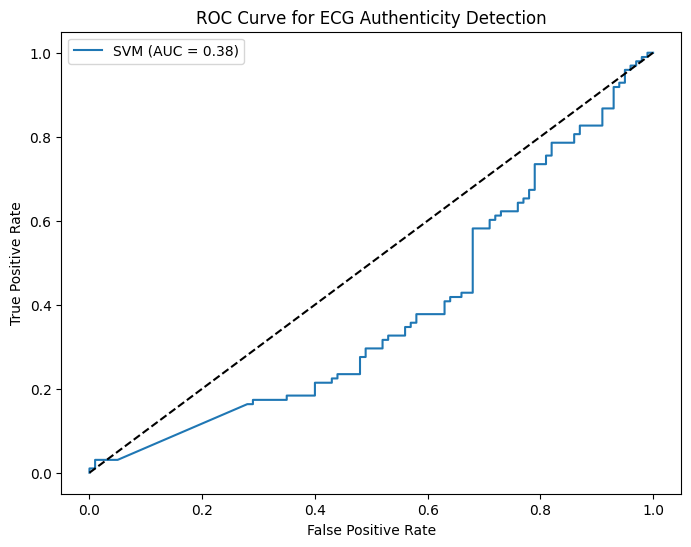

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from biosppy.signals.ecg import engzee_segmenter  # Pan-Tompkins implementation
import matplotlib.pyplot as plt

# ---------------------------
# 0. Prepare Labels (Modify according to your actual data source)
# ---------------------------
# Assuming first 500 are real, rest 487 are synthetic (modify as needed)
n_real = 500
n_fake = 487
y = np.concatenate([np.zeros(n_real), np.ones(n_fake)])

# ---------------------------
# 1. Enhanced Feature Extraction with Pan-Tompkins
# ---------------------------
def extract_ecg_features(signal, sampling_rate=500):
    """Extract comprehensive ECG features using Pan-Tompkins R-peak detection"""
    features = []
    
    # Time-domain features
    features.append(np.mean(signal))          # Mean amplitude
    features.append(np.std(signal))           # Standard deviation
    features.append(np.ptp(signal))           # Peak-to-peak amplitude
    features.append(np.percentile(signal, 75) - np.percentile(signal, 25))  # IQR
    
    # Frequency-domain features
    fft_vals = np.abs(np.fft.rfft(signal))
    features.append(np.mean(fft_vals))        # Mean spectral power
    features.append(np.argmax(fft_vals))      # Dominant frequency component
    
    # R-peak detection using Pan-Tompkins algorithm
    try:
        r_peaks = engzee_segmenter(signal=signal, sampling_rate=sampling_rate)[0]
        rr_intervals = np.diff(r_peaks) / sampling_rate  # Convert to seconds
        
        if len(rr_intervals) > 1:
            # Heart rate variability features
            features.append(np.mean(rr_intervals))     # Mean RR interval
            features.append(np.std(rr_intervals))      # SDNN
            features.append(np.sqrt(np.mean(np.square(np.diff(rr_intervals)))))  # RMSSD
            
            # Morphological features
            qrs_durations = []
            for peak in r_peaks:
                start = max(0, peak - 50)
                end = min(len(signal), peak + 50)
                qrs_durations.append(end - start)
            features.append(np.mean(qrs_durations))    # Average QRS duration
        else:
            # Fallback values if insufficient R-peaks detected
            features.extend([0, 0, 0, 0])
    except Exception as e:
        print(f"R-peak detection error: {e}")
        features.extend([0, 0, 0, 0])
    
    return np.array(features)

# ---------------------------
# 2. Feature Extraction from Lead I Data
# ---------------------------
print("\nExtracting features using Pan-Tompkins algorithm...")
X_features = np.array([extract_ecg_features(sig) for sig in lead_I_data])
print("Feature matrix shape:", X_features.shape)

# Remove samples with invalid features (if any)
valid_indices = ~np.any(np.isnan(X_features), axis=1)
X_clean = X_features[valid_indices]
y_clean = y[valid_indices]

# ---------------------------
# 3. Data Preprocessing
# ---------------------------
# Split dataset with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, 
    test_size=0.2, 
    stratify=y_clean,
    random_state=42
)

# Create preprocessing pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced'))
])

# Hyperparameter tuning
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.1, 1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# ---------------------------
# 4. Evaluation
# ---------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nBest Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Synthetic']))

# Calculate AUC-ROC
auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {auc:.3f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ECG Authenticity Detection')
plt.legend()
plt.show()

动态时间规整（Dynamic Time Warping）：比较ECG信号的形态相似性，真人ECG信号的形态通常更复杂，而机器人生成的ECG可能过于平滑

Template Matching and signal similarity and distance-based comparison and Random Forest for classification

- Measure the similarity between ECG signals by comparing them to multiple real ECG templates
- Calculating the pairwise DTW distances between the signals and randomly chosen templates
- resulting distance matrix used as features for training a Random Forest(RF) classifier

              precision    recall  f1-score   support

         0.0       0.52      0.45      0.48        98
         1.0       0.52      0.59      0.55       100

    accuracy                           0.52       198
   macro avg       0.52      0.52      0.52       198
weighted avg       0.52      0.52      0.52       198



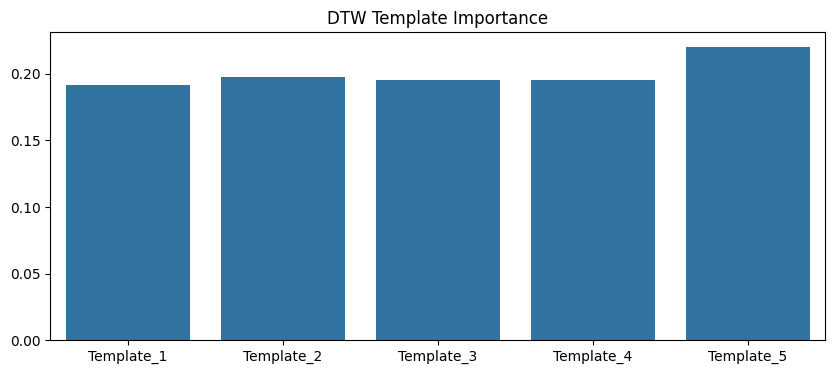

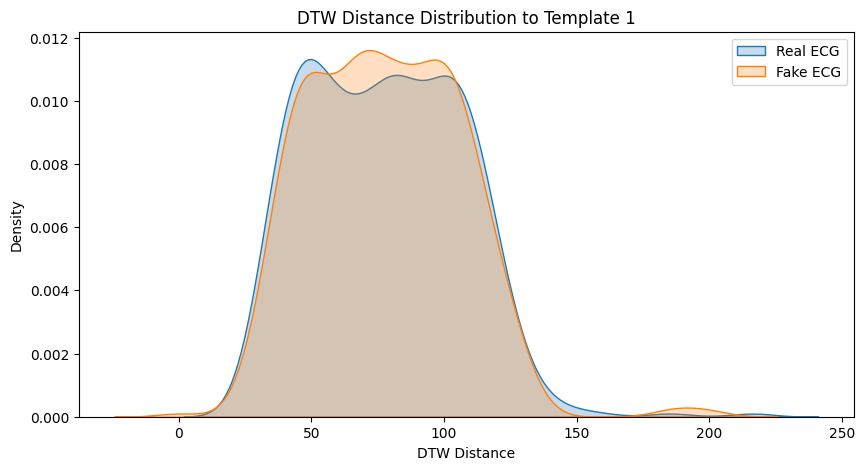

In [6]:
from scipy.signal import resample
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize each ECG signal (normalize independently per sample)
scaler = MinMaxScaler()
normalized_data = np.array([scaler.fit_transform(lead.reshape(-1, 1)).flatten() for lead in lead_I_data])

# Downsample the signals to 500 points (reduce computation while retaining shape features)
downsampled_data = np.array([resample(lead, 500) for lead in normalized_data])

# Split into 'real' and 'generic' data (first 500 records are 'real')
real_data = downsampled_data[:500] 
fake_data = downsampled_data[500:]

# Randomly select N real samples as templates
num_templates = 5
template_indices = np.random.choice(real_data.shape[0], num_templates, replace=False)
templates = real_data[template_indices]

# Custom DTW distance function to compute pairwise DTW distances
def dtw_distance_matrix(data, templates):
    n_samples = data.shape[0]
    n_templates = templates.shape[0]
    dist_matrix = np.zeros((n_samples, n_templates))
    
    for i in range(n_samples):
        for j in range(n_templates):
            # Ensure that data[i] and templates[j] are 1D arrays
            sample = data[i]
            template = templates[j]
            
            # Convert each signal into a list of tuples (e.g., [(sample[0], 0), (sample[1], 0), ...])
            sample_tuples = [(value, 0) for value in sample]
            template_tuples = [(value, 0) for value in template]
            
            # Check and print the shapes for debugging
            # print(f"Shape of data[{i}]: {sample.shape}, Shape of templates[{j}]: {template.shape}")
            # print(f"Sample tuples: {sample_tuples[:5]}, Template tuples: {template_tuples[:5]}")
            
            # Now, pass the sample and template in tuple format to fastdtw
            distance, _ = fastdtw(sample_tuples, template_tuples, dist=euclidean)
            dist_matrix[i, j] = distance
            
    return dist_matrix

# Calculate DTW distances for each sample against all templates
X = dtw_distance_matrix(downsampled_data, templates)

# Define labels for the classification task (1 for 'real' and 0 for 'generic')
y = np.concatenate([np.ones(real_data.shape[0]), np.zeros(fake_data.shape[0])])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importance
feature_importance = clf.feature_importances_
plt.figure(figsize=(10, 4))
sns.barplot(x=[f"Template_{i+1}" for i in range(num_templates)], y=feature_importance[:num_templates])
plt.title("DTW Template Importance")
plt.show()

# Plot DTW distance distribution for each class (real vs. fake)

# Ensure no NaN or Inf values are in X (DTW distance matrix)
X_clean = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

plt.figure(figsize=(10, 5))
sns.kdeplot(X_clean[y == 0, 0], label="Real ECG", fill=True)
sns.kdeplot(X_clean[y == 1, 0], label="Fake ECG", fill=True)

plt.title("DTW Distance Distribution to Template 1")
plt.xlabel("DTW Distance")
plt.legend()
plt.show()
